In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel, RFECV
from joblib import Parallel, delayed, dump
from datetime import datetime
import logging
import warnings
import os
from typing import List, Tuple, Dict, Optional
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import joblib
warnings.filterwarnings('ignore')

In [ ]:
# Configure logging with file and console output
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[logging.FileHandler('insurance_analysis.log'), logging.StreamHandler()])
logger = logging.getLogger(__name__)

# Set random seed and configure parallel processing
np.random.seed(42)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logging
N_JOBS = 4  
USE_GPU = tf.config.list_physical_devices('GPU')
if USE_GPU:
    logger.info("GPU detected and configured for TensorFlow.")
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Load and validate dataset
def load_dataset(file_path: str) -> pd.DataFrame:
    try:
        data = pd.read_csv(file_path, dtype={'age': 'int16', 'bmi': 'float32', 'children': 'int8',
                                            'expenses': 'float32', 'premium': 'float32'})
        if data.empty:
            raise ValueError("Dataset is empty.")
        logger.info(f"Dataset loaded with {data.shape[0]} rows and {data.shape[1]} columns.")
        return data
    except FileNotFoundError:
        logger.error(f"File not found: {file_path}")
        raise
    except Exception as e:
        logger.error(f"Error loading dataset: {str(e)}")
        raise

data = load_dataset('medical_insurance.csv')

# Data validation and summary
logger.info("Performing data validation and summary.")
print("\n=== Dataset Overview ===")
print(data.info(memory_usage='deep'))
print("\n=== Descriptive Statistics ===")
print(data.describe())

2025-08-15 05:27:56,366 - INFO - Dataset loaded with 1338 rows and 8 columns.
2025-08-15 05:27:56,369 - INFO - Performing data validation and summary.



=== Dataset Overview ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   1338 non-null   int16  
 1   gender                1338 non-null   object 
 2   bmi                   1338 non-null   float32
 3   children              1338 non-null   int8   
 4   discount_eligibility  1338 non-null   object 
 5   region                1338 non-null   object 
 6   expenses              1338 non-null   float32
 7   premium               1338 non-null   float32
dtypes: float32(3), int16(1), int8(1), object(3)
memory usage: 264.3 KB
None

=== Descriptive Statistics ===
               age          bmi     children      expenses      premium
count  1338.000000  1338.000000  1338.000000   1338.000000  1338.000000
mean     39.207025    30.665470     1.094918  13270.422852   262.874664
std      14.049960     6.098382  

2025-08-15 05:28:25,760 - WARNING - Image export failed: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido
. Install 'kaleido' with 'pip install -U kaleido' to enable.


Unique values in gender: ['female' 'male']
Unique values in discount_eligibility: ['yes' 'no']
Unique values in region: ['southwest' 'southeast' 'northwest' 'northeast']


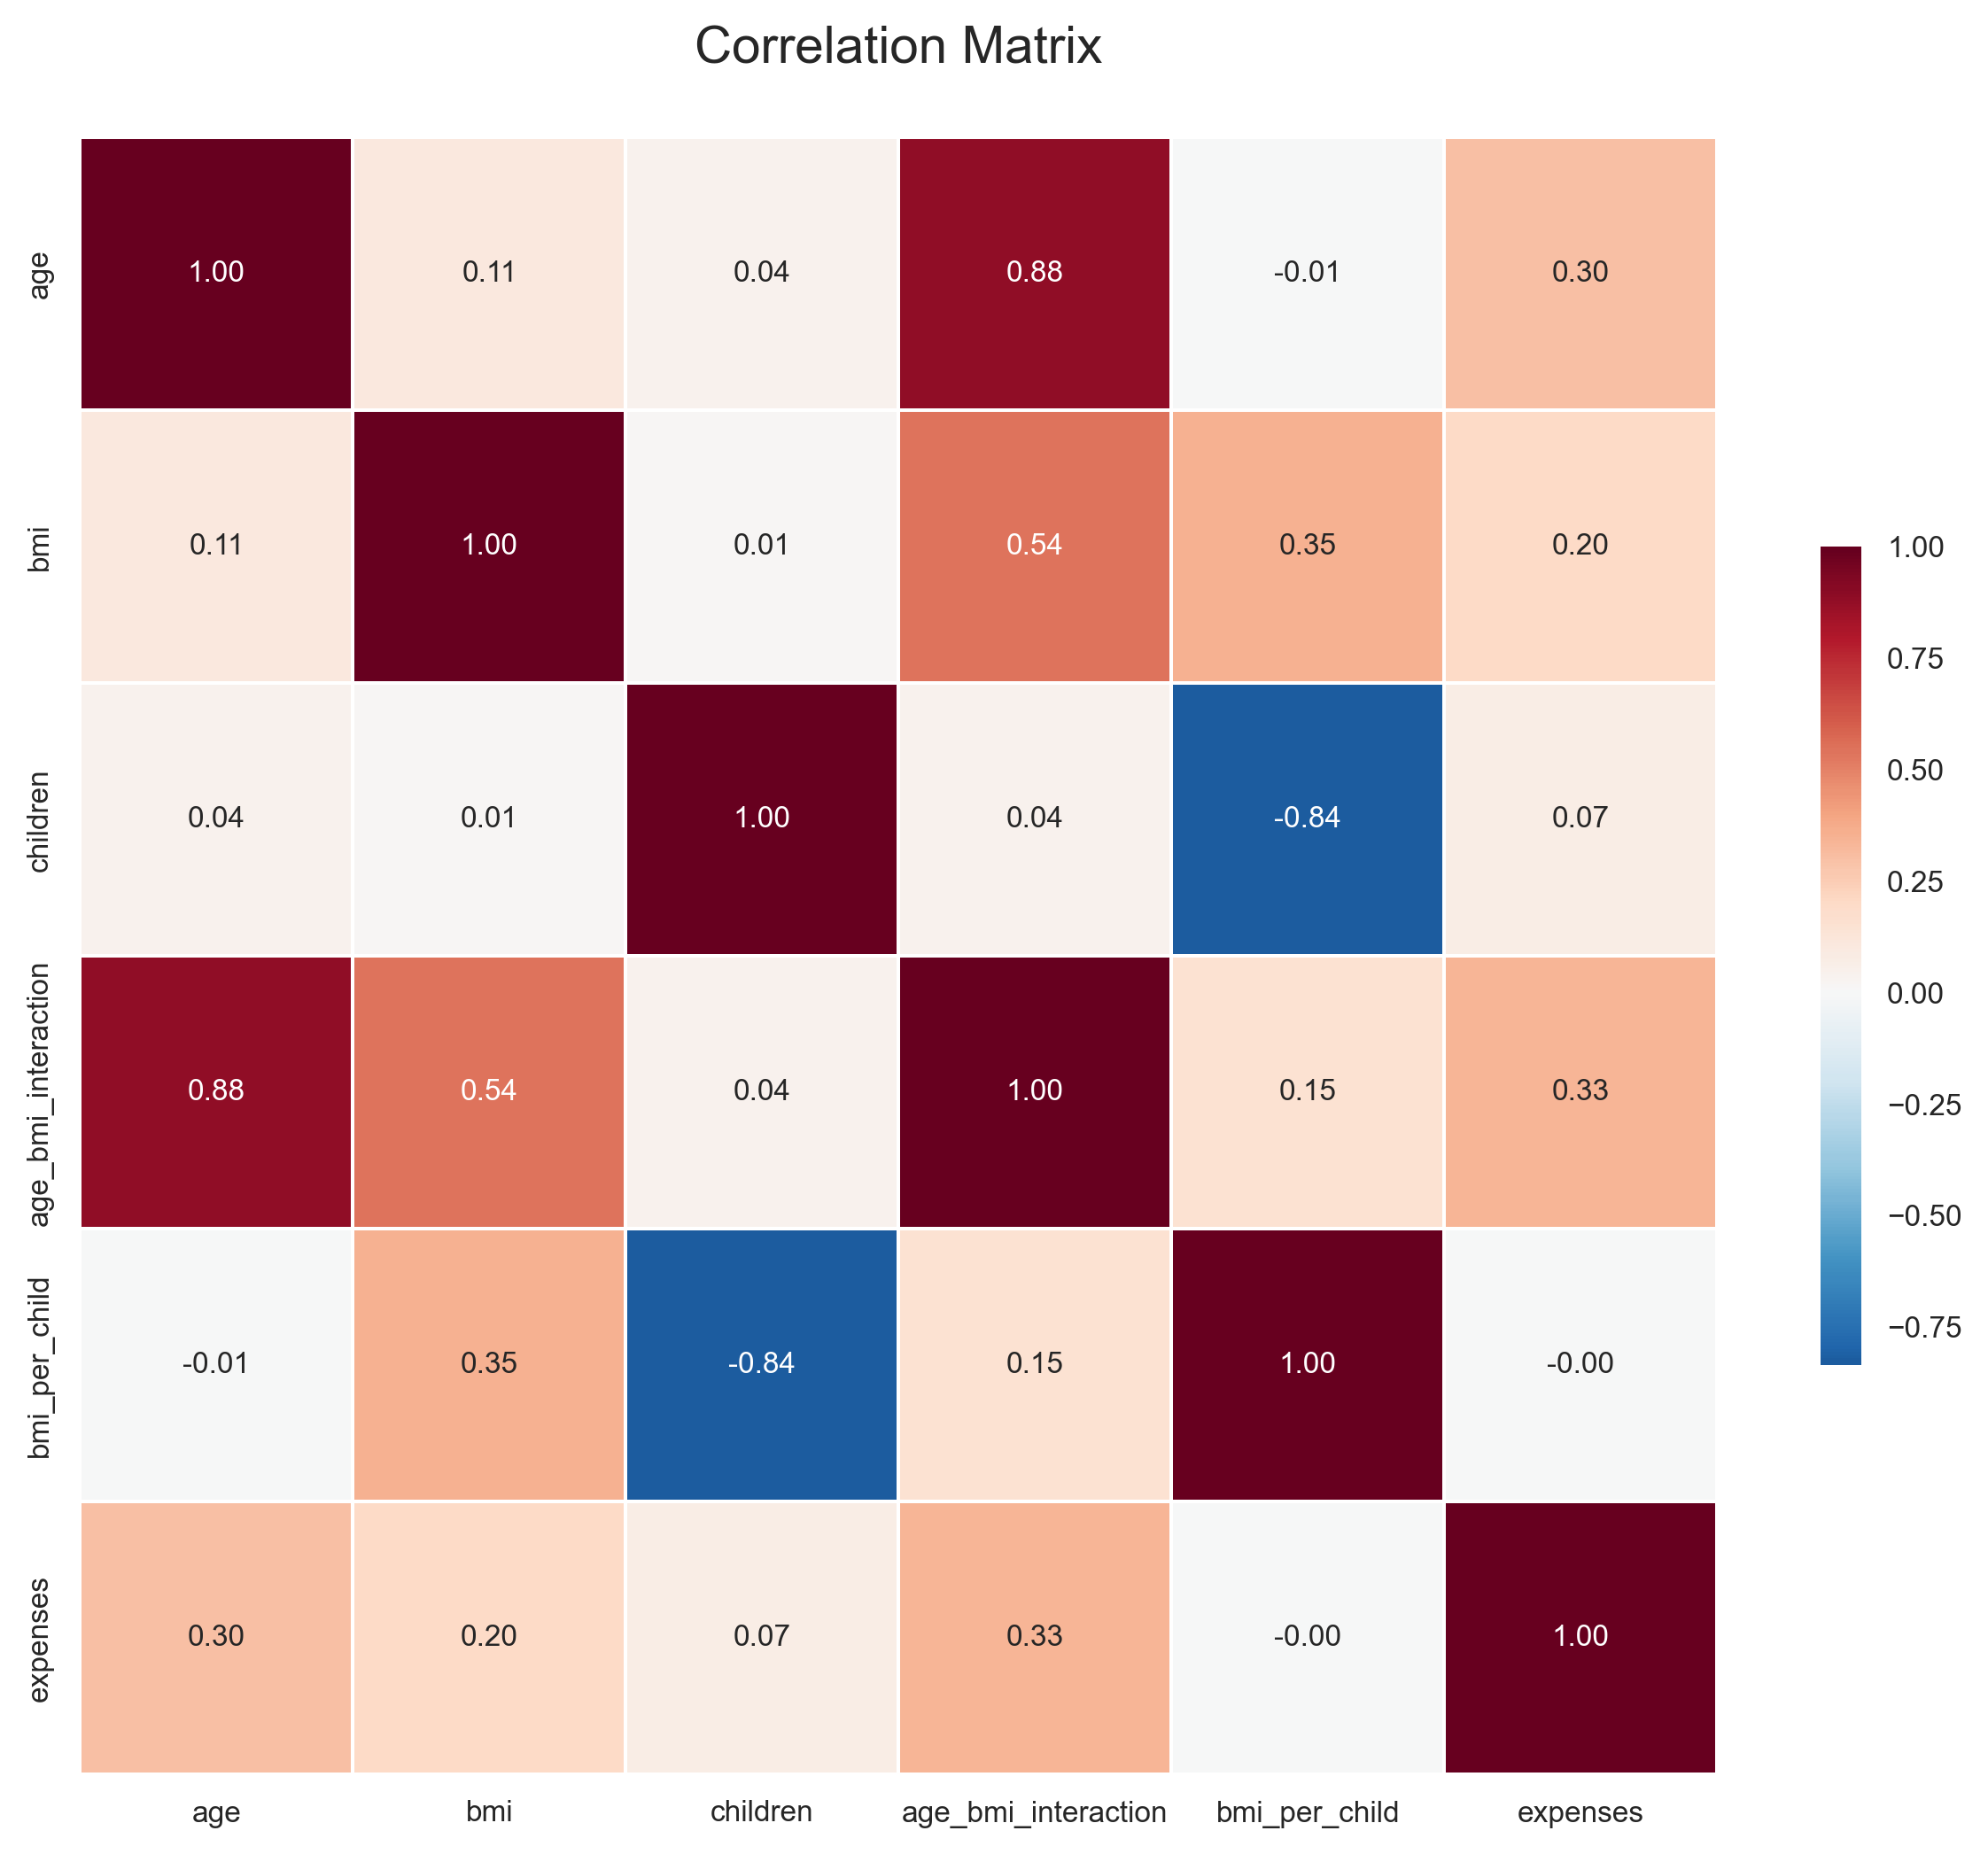

2025-08-15 05:28:26,593 - WARNING - Image export failed: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido
. Install 'kaleido' with 'pip install -U kaleido' to enable.


In [8]:
# Define feature sets
numerical_features = ['age', 'bmi', 'children']
categorical_features = ['gender', 'discount_eligibility', 'region']
target_variable = 'expenses'

# Automated Feature Engineering
def engineer_features(data: pd.DataFrame) -> pd.DataFrame:
    data['age_bmi_interaction'] = data['age'] * data['bmi']
    data['bmi_per_child'] = data['bmi'] / (data['children'] + 1)  # Avoid division by zero
    return data

data = engineer_features(data)
numerical_features.extend(['age_bmi_interaction', 'bmi_per_child'])

# Exploratory Data Analysis (EDA)
plt.style.use('seaborn-v0_8')
plt.rcParams.update({
    'figure.dpi': 300,
    'font.family': 'sans-serif',
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.7
})

def plot_interactive_distributions(data: pd.DataFrame, num_features: List[str], cat_features: List[str], target: str) -> None:
    fig = make_subplots(rows=2, cols=4, subplot_titles=[f.capitalize() for f in num_features + [target] + cat_features])
    for i, feature in enumerate(num_features + [target]):
        row, col = (i // 4) + 1, (i % 4) + 1
        if feature in data.columns:  # Ensure feature exists
            fig.add_trace(go.Histogram(x=data[feature], nbinsx=50 if feature == target else 20, name=feature,
                                       marker=dict(color='#440154'), opacity=0.7), row=row, col=col)
            if feature == target:
                fig.update_xaxes(range=[0, 70000], row=row, col=col)
            fig.update_yaxes(title_text='Density' if feature == target else 'Count', row=row, col=col)
    for i, feature in enumerate(cat_features):
        row, col = (i // 4) + 2, (i % 4) + 1
        if feature in data.columns:  # Ensure feature exists
            counts = data[feature].value_counts()
            colors = px.colors.qualitative.Plotly[:len(counts)]
            fig.add_trace(go.Bar(x=counts.index, y=counts.values, name=feature, marker_color=colors), row=row, col=col)
            fig.update_xaxes(tickangle=45, row=row, col=col)
            print(f"Unique values in {feature}: {data[feature].unique()}")
    fig.update_layout(height=600, width=1200, title_text="Distribution Analysis", showlegend=False)
    try:
        fig.write_image("eda_distributions.png", scale=2)
    except ValueError as e:
        logger.warning(f"Image export failed: {str(e)}. Install 'kaleido' with 'pip install -U kaleido' to enable.")
    fig.show()

plot_interactive_distributions(data, numerical_features, categorical_features, target_variable)

def plot_correlations(data: pd.DataFrame, features: List[str]) -> None:
    plt.figure(figsize=(10, 8))
    sns.heatmap(data[features].corr(), annot=True, cmap='RdBu_r', center=0, fmt='.2f',
                square=True, linewidths=0.5, cbar_kws={'shrink': .5}, annot_kws={'size': 8})
    plt.title('Correlation Matrix', pad=20, size=14)
    plt.savefig('correlation_matrix.png', bbox_inches='tight', dpi=300)
    plt.show()

plot_correlations(data, numerical_features + [target_variable])

def plot_relationships(data: pd.DataFrame, num_features: List[str], cat_features: List[str], target: str) -> None:
    fig = make_subplots(rows=2, cols=3, subplot_titles=[f"{f} vs. {target.capitalize()}" for f in num_features[:3] + cat_features[:3]])
    # Numerical features vs. target (first row)
    for i, feature in enumerate(num_features[:3]):  # Limit to 3 for 2x3 grid
        row, col = 1, i + 1
        if feature in data.columns and target in data.columns:  # Ensure features exist
            fig.add_trace(go.Scatter(x=data[feature], y=data[target], mode='markers', marker=dict(color='purple', opacity=0.6)), row=row, col=col)
            fig.update_xaxes(title_text=feature, row=row, col=col)
            fig.update_yaxes(title_text=target, row=row, col=col)
    # Categorical features vs. target (second row)
    for i, feature in enumerate(cat_features[:3]):  # Limit to 3 for 2x3 grid
        row, col = 2, i + 1
        if feature in data.columns and target in data.columns:  # Ensure features exist
            fig.add_trace(go.Box(x=data[feature], y=data[target], marker_color='blue'), row=row, col=col)
            fig.update_xaxes(tickangle=45, title_text=feature, row=row, col=col)
            fig.update_yaxes(title_text=target, row=row, col=col)
    fig.update_layout(height=600, width=900, title_text="Feature Relationships", showlegend=False)
    try:
        fig.write_image("feature_relationships.png", scale=2)
    except ValueError as e:
        logger.warning(f"Image export failed: {str(e)}. Install 'kaleido' with 'pip install -U kaleido' to enable.")
    fig.show()

plot_relationships(data, numerical_features, categorical_features, target_variable)

In [ ]:
# Outlier Detection and Handling
Q1 = data[target_variable].quantile(0.25)
Q3 = data[target_variable].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 1.5 * IQR
outliers = data[data[target_variable] > outlier_threshold]
logger.info(f"Detected {len(outliers)} outliers in {target_variable}.")
data_no_outliers = data[data[target_variable] <= outlier_threshold]  
print(f"\n=== Outlier Summary ===\nNumber of outliers: {len(outliers)}")
print(outliers[[target_variable, 'age', 'bmi', 'children', 'discount_eligibility', 'region']].head())

# Advanced Preprocessing and Modeling
X = data_no_outliers.drop([target_variable, 'premium'], axis=1)
y = data_no_outliers[target_variable]

# Preprocessing pipeline with feature engineering
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Ensemble Model with Optimized Parameters
gb_model = GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
xgb_model = xgb.XGBRegressor(random_state=42, tree_method='gpu_hist' if USE_GPU else 'auto', n_estimators=100, learning_rate=0.1, n_jobs=N_JOBS)
lgb_model = lgb.LGBMRegressor(random_state=42, n_estimators=100, learning_rate=0.1, n_jobs=N_JOBS)

ensemble = VotingRegressor([
    ('gb', gb_model),
    ('xgb', xgb_model),
    ('lgb', lgb_model)
])

# Simplified pipeline for speed with minimum features
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', RFECV(estimator=GradientBoostingRegressor(random_state=42), cv=3, scoring='r2', n_jobs=N_JOBS, min_features_to_select=5)),
    ('ensemble', ensemble)
])
pipeline.fit(X, y)

# Train-test split and evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_model = pipeline
logger.info("Model training completed with default parameters.")

y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
logger.info(f"Model evaluation: R² = {r2:.4f}, RMSE = {rmse:.2f}")
print(f"\n=== Model Performance ===\nR² Score: {r2:.4f}\nRMSE: {rmse:.2f}")

# Cross-validation with prediction
cv = KFold(n_splits=3, shuffle=True, random_state=42)  # Reduced to 3 folds for speed
y_pred_cv = cross_val_predict(best_model, X, y, cv=cv, n_jobs=N_JOBS)
r2_cv = r2_score(y, y_pred_cv)
rmse_cv = np.sqrt(mean_squared_error(y, y_pred_cv))
logger.info(f"Cross-validation: R² = {r2_cv:.4f}, RMSE = {rmse_cv:.2f}")
print(f"Cross-Validation R²: {r2_cv:.4f}\nCross-Validation RMSE: {rmse_cv:.2f}")

2025-08-15 05:28:49,187 - INFO - Detected 139 outliers in expenses.



=== Outlier Summary ===
Number of outliers: 139
        expenses  age        bmi  children discount_eligibility     region
14  39611.761719   27  42.099998         0                  yes  southeast
19  36837.468750   30  35.299999         0                  yes  southwest
23  37701.878906   34  31.900000         1                  yes  northeast
29  38711.000000   31  36.299999         2                  yes  southwest
30  35585.578125   22  35.599998         0                  yes  southwest


2025-08-15 05:29:07,114 - INFO - Model training completed with default parameters.
2025-08-15 05:29:07,126 - INFO - Model evaluation: R² = 0.8528, RMSE = 3029.94


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 1199, number of used features: 10
[LightGBM] [Info] Start training from score 9927.753534

=== Model Performance ===
R² Score: 0.8528
RMSE: 3029.94


2025-08-15 05:29:24,103 - INFO - Cross-validation: R² = 0.5866, RMSE = 4654.07


Cross-Validation R²: 0.5866
Cross-Validation RMSE: 4654.07


In [11]:
# Interactive Visualization of Predictions
def plot_interactive_predictions(y_test: np.ndarray, y_pred: np.ndarray, y_cv: np.ndarray) -> None:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=y_test, y=y_pred, mode='markers', name='Test Predictions', marker=dict(color='green', opacity=0.5)))
    fig.add_trace(go.Scatter(x=y, y=y_cv, mode='markers', name='CV Predictions', marker=dict(color='blue', opacity=0.3)))
    fig.add_trace(go.Scatter(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], mode='lines', name='Perfect Prediction', line=dict(color='red', dash='dash')))
    fig.update_layout(title='Actual vs. Predicted Expenses', xaxis_title='Actual Expenses ($)', yaxis_title='Predicted Expenses ($)',
                      height=600, width=800, legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
    try:
        fig.write_image("actual_vs_predicted.png", scale=2)
    except ValueError as e:
        logger.warning(f"Image export failed: {str(e)}. Install 'kaleido' with 'pip install -U kaleido' to enable.")
    fig.show()

plot_interactive_predictions(y_test, y_pred, y_pred_cv)

# Feature Importance Analysis
preprocessed_data = best_model.named_steps['preprocessor'].transform(X)
n_features = preprocessed_data.shape[1]  # Number of features after preprocessing
selected_features_mask = best_model.named_steps['feature_selection'].support_[:n_features]  # Limit to preprocessed features
all_feature_names = (numerical_features + 
                    list(best_model.named_steps['preprocessor']
                         .named_transformers_['cat']
                         .named_steps['onehot']
                         .get_feature_names_out(categorical_features)))
selected_feature_names = [name for name, mask in zip(all_feature_names, selected_features_mask) if mask]
importances = np.mean([est.feature_importances_ for est in best_model.named_steps['ensemble'].estimators_], axis=0)[:n_features]

# Ensure lengths match
if len(selected_feature_names) != len(importances):
    logger.warning(f"Length mismatch: selected_feature_names={len(selected_feature_names)}, importances={len(importances)}. Trimming to minimum length.")
    min_length = min(len(selected_feature_names), len(importances))
    selected_feature_names = selected_feature_names[:min_length]
    importances = importances[:min_length]

feature_importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

def plot_interactive_feature_importance(df: pd.DataFrame) -> None:
    fig = go.Figure(data=[go.Bar(x=df['Importance'], y=df['Feature'], orientation='h',
                                 marker=dict(colorscale='Viridis', cmin=0, cmax=1, color=df['Importance']),
                                 text=df['Importance'].round(3), textposition='auto')])
    fig.update_layout(title='Feature Importance in Expense Prediction', xaxis_title='Importance Score',
                      yaxis_title='Feature', height=600, width=800, margin=dict(l=200))
    try:
        fig.write_image("feature_importance.png", scale=2)
    except ValueError as e:
        logger.warning(f"Image export failed: {str(e)}. Install 'kaleido' with 'pip install -U kaleido' to enable.")
    fig.show()

plot_interactive_feature_importance(feature_importance_df)

# Model Serialization
model_filename = f'insurance_expenses_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pkl'
dump(best_model, model_filename)
logger.info(f"Model saved as {model_filename} at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Comprehensive Reporting
def generate_report(model: Pipeline, data: pd.DataFrame, y_test: np.ndarray, y_pred: np.ndarray, y_cv: np.ndarray) -> Dict:
    report = {
        'Dataset_Summary': {'Rows': data.shape[0], 'Columns': data.shape[1], 'Memory_Usage_MB': data.memory_usage().sum() / 1024**2},
        'Model_Performance': {'R2_Test': r2_score(y_test, y_pred), 'RMSE_Test': np.sqrt(mean_squared_error(y_test, y_pred)),
                              'R2_CV': r2_score(y, y_cv), 'RMSE_CV': np.sqrt(mean_squared_error(y, y_cv))},
        'Feature_Importance': feature_importance_df.to_dict(),
        'Outliers': len(outliers),
        'Best_Parameters': {'Note': 'Default parameters used for speed'}
    }
    with open('analysis_report.json', 'w') as f:
        import json
        json.dump(report, f, indent=4)
    return report

report = generate_report(best_model, data_no_outliers, y_test, y_pred, y_pred_cv)
logger.info("Comprehensive report generated as 'analysis_report.json'")
logger.info("Analysis completed successfully at %s", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2025-08-15 05:29:48,256 - WARNING - Image export failed: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido
. Install 'kaleido' with 'pip install -U kaleido' to enable.


2025-08-15 05:29:48,297 - WARNING - Length mismatch: selected_feature_names=3, importances=10. Trimming to minimum length.
2025-08-15 05:29:48,331 - WARNING - Image export failed: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido
. Install 'kaleido' with 'pip install -U kaleido' to enable.


2025-08-15 05:29:48,374 - INFO - Model saved as insurance_expenses_model_20250815_052948.pkl at 2025-08-15 05:29:48
2025-08-15 05:29:48,381 - INFO - Comprehensive report generated as 'analysis_report.json'
2025-08-15 05:29:48,382 - INFO - Analysis completed successfully at 2025-08-15 05:29:48
